<div align="center">
    <h1>Υπολογιστική Γεωμετρία (1η Εργασία)</h1>
</div>

### **Ρυθμίσεις Γραφικών**
Παρακάτω ορίσουμε μερικές ρυθμίσεις οι οποίες θα φέρουν μία **καλύτερη οπτικοποίηση** των αποτελεσμάτων που θα εξάγουμε στην συνέχεια. Κάποιες από αυτές μπορείτε και να **επεξεργαστείτε**, και να τις διαμορφώσετε ανάλογα με τις προτιμήσεις σας.

In [66]:
from matplotlib import pyplot as plt

# Change this according to your theme. 
# For dark theme use 'dark_background'
# For light theme use 'default'
plots_theme = "dark_background"

plt.style.use(plots_theme)
grid_color = "#373737" if plots_theme == 'dark_background' else "#CDCDCD"

### Ορισμός Σημείου (Point Definition)
Θα ξεκινήσουμε την υλοποίησή μας ορίζοντας τη **γενική κλάση** που θα αναπαριστά ένα **σημείο** στο $\mathbb{R}^2$ με συντεταγμένες $x$ και $y$.

In [67]:
class Vector2D:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"({self.x:.3f}, {self.y:.3f})"


### Ορισμός Κυρτού Περιβλήματος (Convex Hull Definition)
Θα συνεχίσουμε ορίζοντας τη **κλάση** η οποία θα αναπαριστά ένα **κυρτό περίβλημα**, το οποίο θα αποτελείται από **σημεία** στον $\mathbb{R}^2$ χώρο, καθώς και **ακμές** οι οποίες θα υποδηλώνουν τις άκρες του περιβλήματος.

In [68]:
import numpy as np
from matplotlib import pyplot as plt

class Convex_Hull:
  def __init__(self, points: np.ndarray[Vector2D], hull_points: np.ndarray[Vector2D]):
    self.points = points
    self.hull_points = hull_points
    self.edges = self.__construct_edges(hull_points)

  def __construct_edges(self, hull_points: np.ndarray[Vector2D]):
    """ Constructs the edges list of the convex hull. """
    edges = []

    for i in range(len(hull_points) - 1):
        edges.append((hull_points[i], hull_points[i + 1]))
    edges.append((hull_points[-1], hull_points[0]))

    return edges

  def __repr__(self):
    return f"Convex_Hull\n-points={self.points}\n-edges={self.edges}"

  def __eq__(self, other):
    """ Checks whether two convex hulls are the same. """
    points_equality: bool = self.points == other.points
    hull_points_equality: bool = self.hull_points == other.hull_points
    edges_equality: bool = self.edges == other.edges
    
    return points_equality and hull_points_equality and edges_equality
  
  def plot(self, axes: plt.axes = None, title: str = ""):
    """
    Plots the convex hull. This function will plot the points and edges of the convex hull.
    """
    if axes is not None:
      axes.scatter([point.x for point in self.points], [point.y for point in self.points], color='#339AFF', s=10)

      # Plot the edges of the convex hull
      for edge in self.edges:
        axes.plot([edge[0].x, edge[1].x], [edge[0].y, edge[1].y], color='#25CA2B')

      axes.axis('off')
      axes.set_title(title)
    else:
      plt.scatter([point.x for point in self.points], [point.y for point in self.points], color='#339AFF', s=10)

      # Plot the edges of the convex hull
      for edge in self.edges:
        plt.plot([edge[0].x, edge[1].x], [edge[0].y, edge[1].y], color='#25CA2B')

      plt.axis('off')
      plt.title(title)
      plt.show()

### Ορισμός Γενικής Έννοιας του Αλγορίθμου Εύρεσης ΚΠ2
Στη συνέχεια θα ορίσουμε τη **γενική αφηρημένη κλάση** (abstract) του αλγορίθμου **εύρεσης** ενός **κυρτού περιβλήματος**. Κάθε αλγόριθμος που θα υλοποιήσουμε στη συνέχεια θα **κληρονομεί** αυτή την κλάση και δωσμένου ενός συνόλου από σημεία, θα υλοποιεί τη δικιά του μέθοδο εύρεσης του κυρτού περιβλήματος.

In [69]:
import numpy as np
from abc import ABC, abstractmethod


class ConvexHullSolutionAlgorithm(ABC):

  @abstractmethod
  def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    ...


### Κατασκευή βοηθητικών συναρτήσεων
Πρωτού ασχοληθούμε με τον πρώτο αλγόριθμό μας, θα ορίσουμε μερικές συναρτήσεις οι οποίες θα μας βοηθήσουν με τη κατασκευή των αλγορίθμων μας. Συγκεκριμένα θα ορίσουμε μία συνάρτηση`are_collinear()` η οποία θα ελέγχει εάν **3 σημεία** στον $\mathbb{R}^2$  είναι **συνευθειακά**, καθώς και άλλη μία συνάρτηση `is_between()` η οποία θα ελέγχει εάν ένα σημείο είναι **ανάμεσα** από άλλα δύο. 

Επομένως ο συνδιασμός των συναρτήσεων `are_collinear()` και `is_between()` θα μας δείχνει εάν ένα σημείο είναι **εσωτερικό σημείο** του ευθυγράμμου τμήματος που ορίσουν δύο άλλα σημεία. 

Επίσης θα ορίσουμε δύο συναρτήσεις `CCW()` και `CW()` οι οποίες θα μας βοηθήσουν με **κατηγορήματα προσανατολισμού** και θα δείχνουν εάν 3 σημεία ορίζουν **θετική** ή **αρνητική** στροφή.

In [70]:
def are_collinear(p1: Vector2D, p2: Vector2D, p3: Vector2D) -> bool:
    # Check for vertical line to avoid division by zero
    if p2.x - p1.x == 0 or p3.x - p2.x == 0:
        return p2.x - p1.x == p3.x - p2.x
    
    # Calculate slopes
    slope1 = (p2.y - p1.y) / (p2.x - p1.x)
    slope2 = (p3.y - p2.y) / (p3.x - p2.x)
    
    return slope1 == slope2

def is_between(p2: Vector2D, p1: Vector2D, p3: Vector2D) -> bool:
    """ Checks whether p1, p2 and p3 are collinear and p2 is between p1 and p3. """
    return (
        min(p1.x, p3.x) <= p2.x <= max(p1.x, p3.x) and
        min(p1.y, p3.y) <= p2.y <= max(p1.y, p3.y)
    )

def CCW(p1: Vector2D, p2: Vector2D, p3: Vector2D) -> bool:
    # Define the supporting matrix for the three points to determine the orientation of the points
    matrix: np.ndarray[np.ndarray[float]] = np.array([
      [1, p1.x, p1.y], 
      [1, p2.x, p2.y], 
      [1, p3.x, p3.y]
    ])
    return np.linalg.det(matrix)



### Ορισμός Αυξητικού Αλγορίθμου (Graham's Scan Algorithm)
Θα ξεκινήσουμε ορίζοντας τον πρώτο μας αλγόριθμο, ο οποίος είναι ο **Ααυξητικός Αλγόριθμος** (Graham's Scan Algorithm). Ο αλγόριθμος αναπαριστάται με μία κλάση όπως φαίνεται παρακάτω όπου μπορεί κάποιος να τον καλέσει χρησιμοποιώντας τη μέθοδο `__call__()`.

In [71]:
import numpy as np

class GrahamScanAlgorithm(ConvexHullSolutionAlgorithm):
  def __construct_upper_hull(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    L_upper: np.ndarray[Vector2D] = [points[0], points[1]]

    # Construct the upper hull of the convex hull
    for i in range(2, len(points)):
      L_upper.append(points[i])
      while len(L_upper) > 2 and not CCW(L_upper[-3], L_upper[-2], L_upper[-1]) < 0:
        L_upper.pop(-2)

    return L_upper
  
  def __construct_lower_hull(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    L_lower: np.ndarray[Vector2D] = [points[-1], points[-2]]

    # Construct the lower hull of the convex hull
    for i in range(len(points) - 3, -1, -1):
      L_lower.append(points[i])
      while len(L_lower) > 2 and not CCW(L_lower[-3], L_lower[-2], L_lower[-1]) < 0:
        L_lower.pop(-2)

    # Remove the first and last points from L_lower to avoid duplication
    L_lower.pop(0)
    L_lower.pop(-1)

    return L_lower

  def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    # Sort the points by their x-coordinate, then by their y-coordinate, and insert p1 and p2 to the L_upper set
    points: np.ndarray[Vector2D] = sorted(points, key=lambda p: (p.x, p.y))
    
    # Construct the upper and lower hulls of the convex hull
    L_upper: np.ndarray[Vector2D] = self.__construct_upper_hull(points)
    L_lower: np.ndarray[Vector2D] = self.__construct_lower_hull(points)

    # Merge the L_upper and L_lower sets to form the convex hull and return the result
    L: np.ndarray[Vector2D] = L_upper + L_lower

    return L

### Δοκιμή Αλγορίθμου
Ας δοκιμάσουμε τον αλγόριθμό. Για αρχή θα αρχικοποιήσουμε ένα σύνολο με **100 τυχαία** σημεία στο $\mathbb{R}^2$ χώρο. θα δημιουργήσουμε **δύο** σύνολα δεδομένων. Το ένα σύνολο θα περιέχει τυχαία δεδομένα όπου το χωρίο που θα καταλαμβάνουν χώρο με **ορθογωνιακό** σχήμα, και το δεύτερο σύνολο θα περιέχει δεδομένα τα οποία θα καταλαμβάνουν χώρο με **κυκλικό** σχήμα.

In [72]:
import numpy as np

POINTS_COUNT = 1000

# Generate the rectangle set containing the random points
rectangle_points_set: np.ndarray[Vector2D] = []
for i in range(POINTS_COUNT):
  random_point = Vector2D(x=np.random.sample(), y=np.random.sample())
  rectangle_points_set.append(random_point)

# Generate the circular set containing the random points
circular_points_set: np.ndarray[Vector2D] = []
for i in range(POINTS_COUNT):
  angle = np.random.uniform(0, 2 * np.pi)
  radius = np.random.uniform(0, 1)
  x, y = radius * np.cos(angle), radius * np.sin(angle)
  random_point = Vector2D(x, y)
  circular_points_set.append(Vector2D(x, y))


Για να καταλάβουμε καλύτερα αυτά τα σύνολα δεδομένων, ας τα **οπτικοποιήσουμε**.

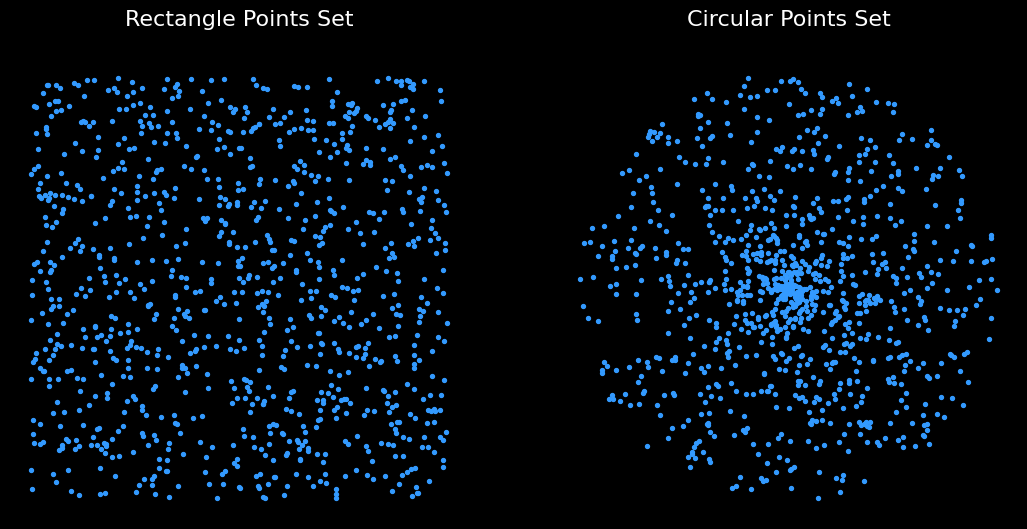

In [73]:
figure, axes = plt.subplots(1, 2, figsize=(13, 6))

for s_point, c_point in zip(rectangle_points_set, circular_points_set):
  axes[0].scatter(s_point.x, s_point.y, color='#339AFF', s=8)
  axes[1].scatter(c_point.x, c_point.y, color='#339AFF', s=8)

axes[0].set_title('Rectangle Points Set\n', fontsize=16)
axes[0].axis('off')
axes[1].set_title('Circular Points Set\n', fontsize=16)
axes[1].axis('off')

plt.show()

### Εύρεση του κυρτού περιβλήματος (Convex Hull Calculation)
Έχοντας δημιουργήσει τα σύνολα δεδομένων μας, ήρθε η ώρα να δοκιμάσουμε τον αλγόριθμό μας.

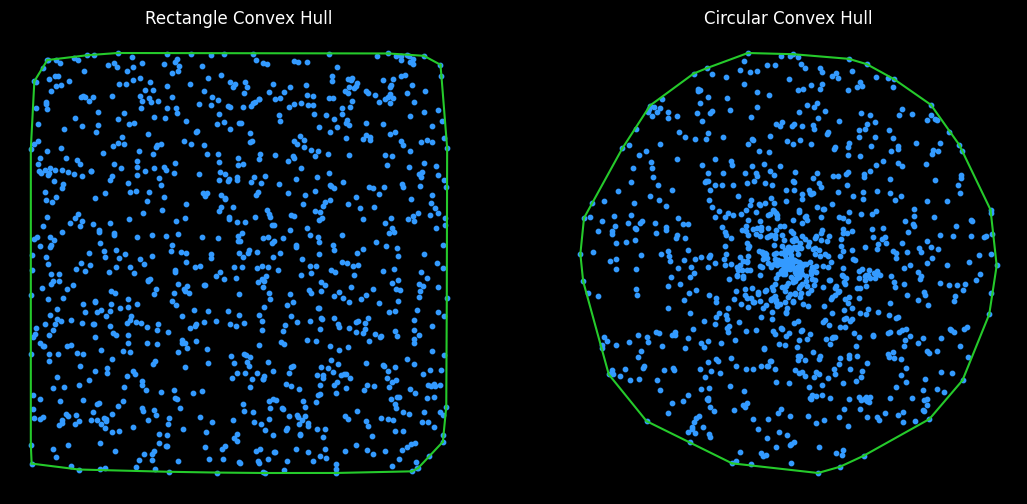

In [74]:
# Initialize the algorithm
gs_algorithm = GrahamScanAlgorithm()

# Compute the convex hull for the rectangle and the circular points set
rect_gs_result = gs_algorithm(np.array(rectangle_points_set))
circ_gs_result = gs_algorithm(np.array(circular_points_set))

# Create the convex hull objects
rect_convex_hull = Convex_Hull(rectangle_points_set, rect_gs_result)
circ_convex_hull = Convex_Hull(circular_points_set, circ_gs_result)

# Plot the convex hulls
figure, axes = plt.subplots(1, 2, figsize=(13, 6))
rect_convex_hull.plot(axes[0], title="Rectangle Convex Hull")
circ_convex_hull.plot(axes[1], title="Circular Convex Hull")

Όπως παρατηρούμε από τα παραπάνω διαγράμματα, ο αλγόριθμός μας λειτούργησε αποτελεσματικά για τα δύο σύνολα δεδομένων.

### Αλγόριθμος Περιτυλίγματος (Gift Wrapping)
Θα συνεχίσουμε υλοποιώντας τους υπόλοιπους αλγορίθμους, ξεκινώντας με τον **Αλγόριθμο Του Περιτυλίγματος** (Gift Wrapping Algorithm)

In [75]:
class GiftWrappingAlgorithm(ConvexHullSolutionAlgorithm):
    def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
        # Create a copy of the points array and compute the leftmost point
        S = points.copy()
        r0 = min(S, key=lambda p: (p.x, p.y))
        r = r0
        
        # Initialize the array containing the selcted points for the convex hull
        selected_points: np.ndarray[Vector2D] = [r]
        
        while True:
            # Let u be a point on the convex hull that has not been selected yet
            remaining_points: np.ndarray[Vector2D] = [p for p in S if p not in selected_points]
            u = remaining_points[0]
            
            # Check all the other points until we find the next prospective point for the hull points 
            for t in points:
                if CCW(r, u, t) > 0 or (are_collinear(r, u, t) and is_between(u, r, t)):
                    u = t
            
            # Check if the current point selected is the first point. If that is the case the process 
            # has been completed.
            # Otherwise we append the point on the hull points and remove it from our points array.
            if u == r0:
                return selected_points
            else:
                r = u
                S.remove(r)
                selected_points.append(r)


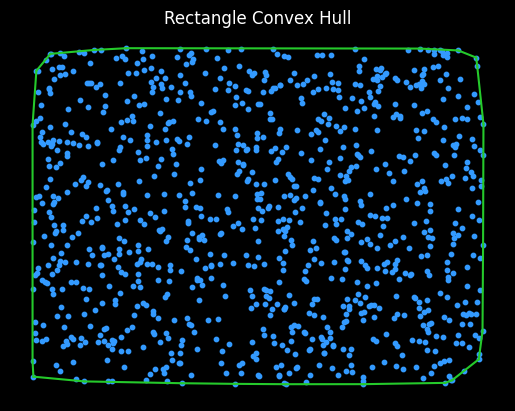

In [76]:
gw_algorithm = GiftWrappingAlgorithm()
result = gw_algorithm(rectangle_points_set)

# Create the convex hull object
convex_hull = Convex_Hull(rectangle_points_set, result)
convex_hull.plot(title="Rectangle Convex Hull")

### Αλγόριθμος Διαίρει και Βασίλευε (Devide and conquer)

In [77]:
# class DevideAndConquerAlgorithm(ConvexHullSolutionAlgorithm):
#     def __merge(self, A: np.ndarray[Vector2D], B: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
#         n1, n2 = len(A), len(B)

#         # Find upper tangent
#         left_index = n1 - 1
#         right_index = 0

#         while True:
#             moved = False
#             if CCW(A[left_index], B[right_index], B[(right_index + 1) % n2]):
#                 right_index = (right_index + 1) % n2
#                 moved = True
#             if CW(B[right_index], A[left_index], A[(left_index - 1) % n1]):
#                 left_index = (left_index - 1) % n1
#                 moved = True
#             if not moved:
#                 break

#         upper_left = left_index
#         upper_right = right_index

#         # Find lower tangent
#         left_index = n1 - 1
#         right_index = 0

#         while True:
#             moved = False
#             if CW(A[left_index], B[right_index], B[(right_index - 1) % n2]):
#                 right_index = (right_index - 1) % n2
#                 moved = True
#             if CCW(B[right_index], A[left_index], A[(left_index + 1) % n1]):
#                 left_index = (left_index + 1) % n1
#                 moved = True
#             if not moved:
#                 break

#         lower_left = left_index
#         lower_right = right_index

#         # Merge hulls
#         hull = []
#         index = upper_left
#         while index != lower_left:
#             hull.append(A[index])
#             index = (index + 1) % n1
#         hull.append(A[lower_left])

#         index = lower_right
#         while index != upper_right:
#             hull.append(B[index])
#             index = (index + 1) % n2
#         hull.append(B[upper_right])

#         return hull
            
        
#     def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
#         # Sort the points by their x-coordinate, then by their y-coordinate
#         points = sorted(points, key=lambda p: (p.x, p.y))
#         n: int = len(points)
        
#         # Base Case
#         if n <= 3:
#             return points
        
#         # Devide the set of points to two individual sub-sets
#         left_points, right_points = points[:n//2], points[n//2:]

#         # Recursive call of the algorithm for the two individual sub-sets
#         left_result = self.__call__(left_points)
#         right_result = self.__call__(right_points)

#         # TODO: Merge the two hulls
#         return self.__merge(left_result, right_result)

In [78]:
# import numpy as np

# POINTS_COUNT = 100

# # Generate the rectangle set containing the random points
# rectangle_points_set: np.ndarray[Vector2D] = []
# for i in range(POINTS_COUNT):
#   random_point = Vector2D(x=np.random.sample(), y=np.random.sample())
#   rectangle_points_set.append(random_point)


In [79]:
# dq_algorithm = DevideAndConquerAlgorithm()
# result = dq_algorithm(rectangle_points_set)

# hull = Convex_Hull(rectangle_points_set, result)
# hull.plot()

### Αλγόριθμος Quick Hull

In [80]:
class QuickHullAlgorithm(ConvexHullSolutionAlgorithm):
    def __get_distance(self, A: Vector2D, B: Vector2D, p: Vector2D) -> float:
        numerator = abs((B.y - A.y) * p.x - (B.x - A.x) * p.y + B.x * A.y - B.y * A.x)
        denominator = np.sqrt((B.y - A.y) ** 2 + (B.x - A.x) ** 2)
    
        return numerator / denominator
    
    def __find_hull(self, A: Vector2D, B: Vector2D, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
        if len(points) <= 1:
            return points
        
        # Find the point with maximum distance from the line AB
        C = max(points, key=lambda p: self.__get_distance(A, B, p))
        
        # Find the points on the left and right side of the line AC
        M = [p for p in points if CCW(A, C, p) > 0]
        N = [p for p in points if CCW(C, B, p) > 0]
        
        # Recursively find the hulls for the two sets of points
        L1 = self.__find_hull(A, C, M)
        L2 = self.__find_hull(C, B, N)
    
        return L1 + [C] + L2
        
    def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
        # Find the leftmost, rightmost, topmost and bottommost points
        leftmost, rightmost = min(points, key=lambda p: p.x), max(points, key=lambda p: p.x)
        topmost, bottommost = max(points, key=lambda p: p.y), min(points, key=lambda p: p.y)
        
        # Find the points on the left and right side of the line determined by the leftmost and rightmost points
        L1 = self.__find_hull(bottommost, leftmost, [p for p in points if CCW(bottommost, leftmost, p) > 0])
        L2 = self.__find_hull(leftmost, topmost, [p for p in points if CCW(leftmost, topmost, p) > 0])
        
        # Find the points on the left and right side of the line determined by the topmost and rightmost points
        L3 = self.__find_hull(topmost, rightmost, [p for p in points if CCW(topmost, rightmost, p) > 0])
        L4 = self.__find_hull(rightmost, bottommost, [p for p in points if CCW(rightmost, bottommost, p) > 0])
        
        return [bottommost] + L1 + [leftmost] + L2 + [topmost] + L3 + [rightmost] + L4

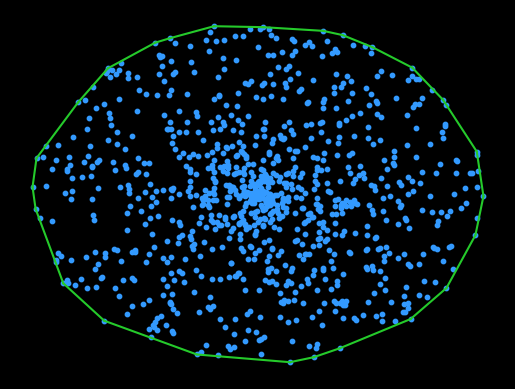

In [81]:
qh_algorithm = QuickHullAlgorithm()
result = qh_algorithm(circular_points_set)

hull = Convex_Hull(circular_points_set, result)
hull.plot()
